<a href="https://colab.research.google.com/github/HuiWangCJLU/FM-Homework/blob/main/%E9%87%91%E8%9E%8D%E9%A3%8E%E9%99%A9%E7%AE%A1%E7%90%86.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

     |████████████████████████████████| 6.4 MB 5.1 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 11.3 MB 4.3 MB/s 
  Attempting uninstall: pandas
    Found existing installation: pandas 1.1.5
    Uninstalling pandas-1.1.5:
      Successfully uninstalled pandas-1.1.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.1.0; python_version >= "3.0", but you have pandas 1.3.5 which is incompatible.


     |████████████████████████████████| 109 kB 4.3 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0


# 第一题

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

df = pdr.get_data_yahoo(['BA','IBM','JPM'], start=dt.datetime(2016,12,20), end=dt.datetime(2017,12,20))['Adj Close']

In [ ]:
df = np.log(df / df.shift(1))
df.dropna(inplace=True)
df.head()

Symbols,BA,IBM,JPM
Date,,,
2016-12-21,0.006946,-0.001613,0.002539
2016-12-22,-0.000127,-0.001615,0.001613
2016-12-23,0.002220,-0.002098,0.001840
2016-12-27,-0.002093,0.002576,0.000918
2016-12-28,-0.008802,-0.005700,-0.007257


In [ ]:
tmp_return = []
tmp_volatility = []

for p in range(1000):
    
    weights = np.random.random(3)
    weights /= np.sum(weights)
    expected_return = np.dot(weights.T, df.mean())*252
    covariance_matrix = df.cov()
    expected_volatility =np.sqrt(np.dot(np.dot(weights.T, covariance_matrix), weights)*252)
    
    tmp_return.append(expected_return)
    tmp_volatility.append(expected_volatility)

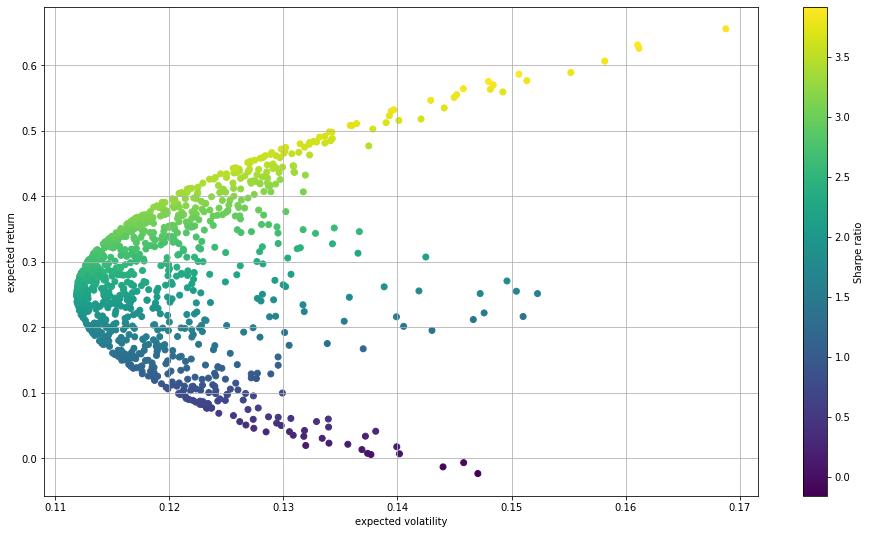

In [ ]:
tmp_return = np.array(tmp_return)
tmp_volatility = np.array(tmp_volatility)

plt.figure(figsize=(16,9))
plt.scatter(tmp_volatility, tmp_return, c=tmp_return/tmp_volatility, marker='o')
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [ ]:
import scipy.optimize as sci_op

def fun_volatility_min(weights):
    covariance_matrix = df.cov()
    expected_volatility = np.dot(np.dot(weights.T, covariance_matrix), weights)*252
    return np.sqrt(expected_volatility)

constraints = {'type':'eq', 'fun':lambda x: np.sum(x)-1.}
bounds = tuple((0,1) for x in range(3))
weights = np.random.random(3)
weights /= np.sum(weights)
initial_guess = weights

opts = sci_op.minimize(fun=fun_volatility_min,
                       x0=initial_guess,
                       method='SLSQP',
                       bounds=bounds,
                       constraints=constraints)
print('最小波动率', opts['fun'])
print (opts)

最小波动率 0.11188099357379197
     fun: 0.11188099357379197
     jac: array([0.11119181, 0.11237475, 0.11191311])
 message: 'Optimization terminated successfully.'
    nfev: 20
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.30125743, 0.40113693, 0.29760563])


In [ ]:
def fun_effective_boundary(weights):
    """The effective boundaries of the portfolio"""
    expected_return = np.dot(weights.T, df.mean())*252
    return expected_return

return_array = np.linspace(0, 0.6, 361)
tmp_plot_volatility = []
for tp_return in return_array:
    constraints = ({'type':'eq', 'fun':lambda x: np.sum(x)-1.},
                  {'type':'eq', 'fun':lambda x: (fun_effective_boundary(x)-tp_return)})
    bounds = tuple((0,1) for x in range(3))
    weights = np.random.random(3)
    weights /= np.sum(weights)
    initial_guess = weights
    opts = sci_op.minimize(fun=fun_volatility_min,
                           x0=initial_guess,
                           method='SLSQP',
                           bounds=bounds,
                           constraints=constraints)
    tmp_plot_volatility.append(opts['fun'])

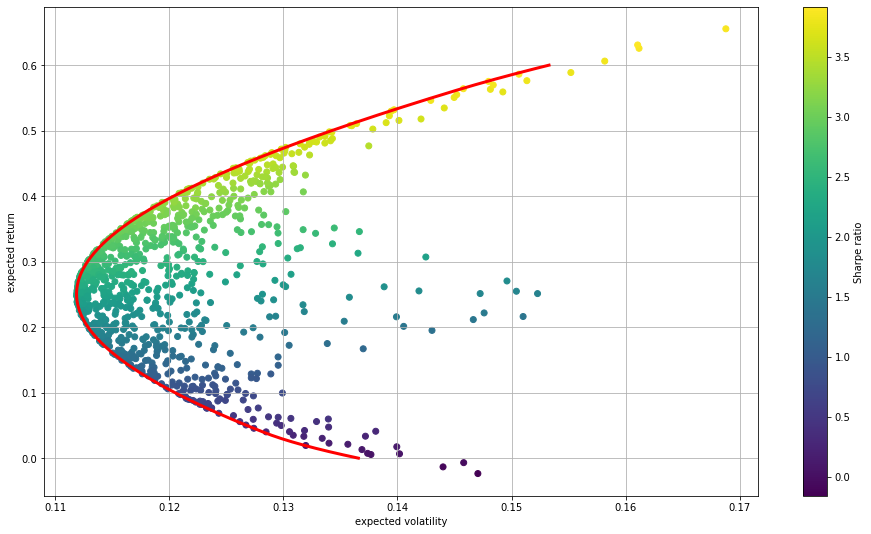

In [ ]:
plt.figure(figsize=(16,9))
plt.scatter(tmp_volatility, tmp_return, c=tmp_return/tmp_volatility, marker='o')
plt.plot(tmp_plot_volatility,return_array, 'r', linewidth=3)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# 第三题看不懂系列

-0.0008966366088441952
0.013561974671866468


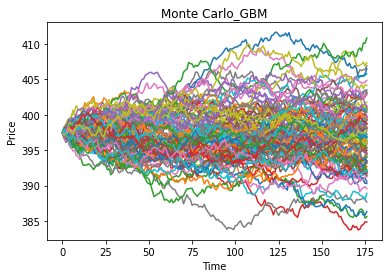

Estimated VaR: 1.8667 %
Estimated VaR of the Portfolio: 18667.0


In [ ]:
#import necessary libraries
import yfinance as yf
import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


"""
Geometric Brownian Motion: Markov process, meaning stock price follows a random walk and is consistent with (at the very least) 
the weak form of the efficient market hypothesis (EMH)—past price information is already incorporated, 
and the next price movement is "conditionally independent" of past price movements.
change in S = (expected mean * Stock Price * Time Period) + 
(volatility of stock * epsilon = Random number generated from the standard normal distribution* Stock Price * Sqrt(Time Period) )
"""
def simulate_GBM(timerange, step_size, number_of_steps, mu, sigma, current_price, VaR_Percentage, show_plot=False):
    forwardpatharray = np.array([[]])
    closeprices = np.array([])
    del_t = timerange/step_size
    for path in range(number_of_steps):
        futurepricelist = np.array([np.float(current_price)])
        for i in range(step_size):
            epsilon = np.random.normal(0, 1)  #generating random number from the standard normal distribution
            S = futurepricelist[-1]
            del_S = mu*S*del_t + sigma*epsilon*S*(np.sqrt(del_t))
            new_S = S + del_S
            futurepricelist = np.append(futurepricelist, new_S)     #adding prices to the list

        if forwardpatharray.shape[1] == 0:
            forwardpatharray = np.array([futurepricelist])
        else:
            forwardpatharray = np.concatenate((forwardpatharray, np.array([futurepricelist])), axis=0)

        closeprices = np.append(closeprices, futurepricelist[-1])

    if show_plot:
        for i in range(forwardpatharray.shape[0]): 
            plt.plot(forwardpatharray[i])
        plt.xlabel('Time')
        plt.ylabel('Price')
        plt.title('Monte Carlo_GBM')
        plt.show()

    VaR = current_price - np.percentile(closeprices, 100 - VaR_Percentage)  #defining VaR
    VaR_in_Perc = round(((-VaR/current_price)*100),4)
    return VaR_in_Perc


#Defining Main Function 

def main_var(tickers, weights, initial_investment, VaR_Percentage):
    
    data = pdr.get_data_yahoo(tickers, start=dt.datetime(2018,12,20)-dt.timedelta(252), end=dt.datetime(2018,12,20))['Adj Close']
    ret_data = data.pct_change()
    log_ret_data = np.log(ret_data)
    ret_data = ret_data.dropna()
    
    weighted_returns = (weights * ret_data)
    portfolio_returns = pd.DataFrame()
    portfolio_returns['Adj Close'] = data.sum(axis=1)
    portfolio_returns['Log Return'] = weighted_returns.sum(axis=1)
    portfolio_returns.to_csv("data.csv")

    print(np.mean(portfolio_returns['Log Return']))
    print(np.std(portfolio_returns['Log Return']))
    VaR1 = simulate_GBM(1, len(portfolio_returns), 100, np.mean(portfolio_returns['Log Return']), np.std(portfolio_returns['Log Return']), portfolio_returns['Adj Close'][-1], VaR_Percentage, True)
    print(f'Estimated VaR: {VaR1} %')
    
    VaR_Investment = VaR1 * (initial_investment/100)
    print(f'Estimated VaR of the Portfolio: {VaR_Investment}')

#Provide Values Below
t = ['BA','IBM']  #tickers
w = np.array([.5, .5])                               #weights
i = 1000000                                                    #investment
v = 5                                                          #confidence level

#Calling main function
main_var(t, w, i, v)

#第三题自己打得版本

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

def simulate_GBM(timerange, steps, paths, mu, sigma, cur_price, VarPerc, show_plot=False):
    patharray = np.array([[]])
    closeprices = np.array([])
    del_t = timerange/steps
    for path in range(paths):
        progresslist = np.array([np.float(cur_price)])
        for i in range(steps):
            epsilon = np.random.normal(0, 1)
            S = progresslist[-1]
            del_S = mu*S*del_t + sigma*epsilon*S*(np.sqrt(del_t))
            new_S = S + del_S
            progresslist = np.append(progresslist, new_S)

        if patharray.shape[1] == 0:
            patharray = np.array([progresslist])
        else:
            patharray = np.concatenate((patharray, np.array([progresslist])), axis=0)

        closeprices = np.append(closeprices, progresslist[-1])

    if show_plot:
        for i in range(patharray.shape[0]):
            plt.plot(patharray[i])
        plt.show()

    VaR = cur_price - np.percentile(closeprices, 100 - VarPerc)
    return VaR

In [ ]:
#data = pdr.get_data_yahoo(t, start=dt.datetime(2018,12,20)-dt.timedelta(252), end=dt.datetime(2018,12,20))['Adj Close']
df2= pdr.get_data_yahoo(t, start=dt.datetime(2017,12,20), end=dt.datetime(2018,12,20))['Adj Close']
df = pdr.get_data_yahoo(t, start=dt.datetime(2015,12,20), end=dt.datetime(2017,12,20))['Adj Close']
df["Adj Close"]=df.sum(axis=1)
df2["Adj Close"]=df2.sum(axis=1)

data2= pdr.get_data_yahoo(t, start=dt.datetime(2017,12,20), end=dt.datetime(2018,12,20))['Adj Close']
data = pdr.get_data_yahoo(t, start=dt.datetime(2015,12,20), end=dt.datetime(2017,12,20))["Adj Close"]

ret_data = data.pct_change()
ret_data = ret_data.dropna()
weighted_returns = (w * ret_data)
rreturn = weighted_returns.sum(axis=1)
df['returns'] = np.log(rreturn+1)

ret_data = data2.pct_change()
ret_data = ret_data.dropna()
weighted_returns = (w * ret_data)
rreturn2 = weighted_returns.sum(axis=1)
df2['returns'] = np.log(rreturn2+1)


In [ ]:
df=df.dropna()
df2=df2.dropna()

Actual VaR: -10.330345633788479


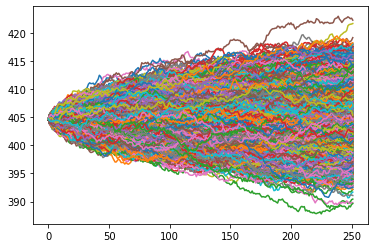

Estimated VaR: -7.11206297228938


In [ ]:
print("Actual VaR:", df['Adj Close'][len(df)-1]*np.percentile(df2['returns'], 5))

print('Estimated VaR:', simulate_GBM(1, len(df2), 10000, np.mean(df['returns']), np.std(df['returns']), df['Adj Close'][len(df)-1], 5, True))

In [ ]:
df

Symbols,BA,IBM,Adj Close,returns
Date,,,,
2015-12-22,127.691177,100.991035,228.682213,-4.288545
2015-12-23,129.197830,101.437668,230.635498,-4.930389
2015-12-24,128.722534,101.225342,229.947876,0.000000
2015-12-28,129.628311,100.756737,230.385048,-2.478294
2015-12-29,132.148438,102.345573,234.494011,-4.045020
...,...,...,...,...
2017-12-14,280.065521,121.594131,401.659653,-6.203629
2017-12-15,280.122742,120.409760,400.532501,-4.248467
2017-12-18,282.219391,121.065117,403.284508,-5.054203


# 第二题

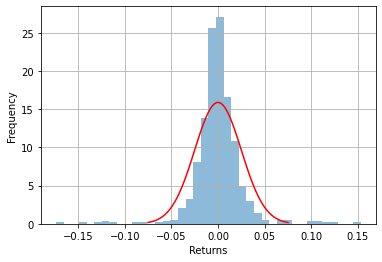

Confidence level      Value at Risk
------------------  ---------------
90%                      -0.0219182
95%                      -0.0315044
99%                      -0.0799384


In [ ]:
#Import necessary libraries
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt

#Data fetching
import yfinance as yf

#Plotting
import matplotlib.pyplot as plt
import seaborn
import matplotlib.mlab as mlab

#Statistical Calculation
from scipy.stats import norm

#Tabular data output
from tabulate import tabulate

#Create our portfolio of equities
tickers = ['IBM','BA', 'JPM']

#Set the investment weights (I arbitrarily picked for example)
weights = np.array([.25, .25, .25])

#Calculating Daily Returns
data = pdr.get_data_yahoo(tickers, start=dt.date.today()-dt.timedelta(1000), end=dt.date.today())['Adj Close']

data['Adj Close Combined'] =  data.iloc[:, 0:4].dot(weights.T)  #creating portfolio Adj Close Price

#From the closing prices, calculate periodic returns
data['Returns'] = data['Adj Close Combined'].pct_change()

df = pd.DataFrame()
df['Returns'] = data['Returns'].dropna()

#Mean and Standard Deviation
mean = np.mean(df['Returns'])
std_dev = np.std(df['Returns'])

df['Returns'].hist(bins = 40, density=True, histtype = 'stepfilled', alpha = 0.5)
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)
plt.xlabel('Returns')
plt.ylabel('Frequency')
plt.grid(True)
plt.plot(x, norm.pdf(x, mean, std_dev), "r")
plt.show()

#Sorting Daily Returns
df.sort_values('Returns', inplace = True, ascending = True)

#Calculating VaR
VaR_90 = df['Returns'].quantile(0.1)
VaR_95 = df['Returns'].quantile(0.05)
VaR_99 = df['Returns'].quantile(0.01)

print (tabulate([['90%', VaR_90], ['95%', VaR_95], ['99%', VaR_99]], headers = ['Confidence level', 'Value at Risk']))